# Modelo de regresión logística

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

Tercil 1 (33.33%): $139,685
Tercil 2 (66.67%): $190,000


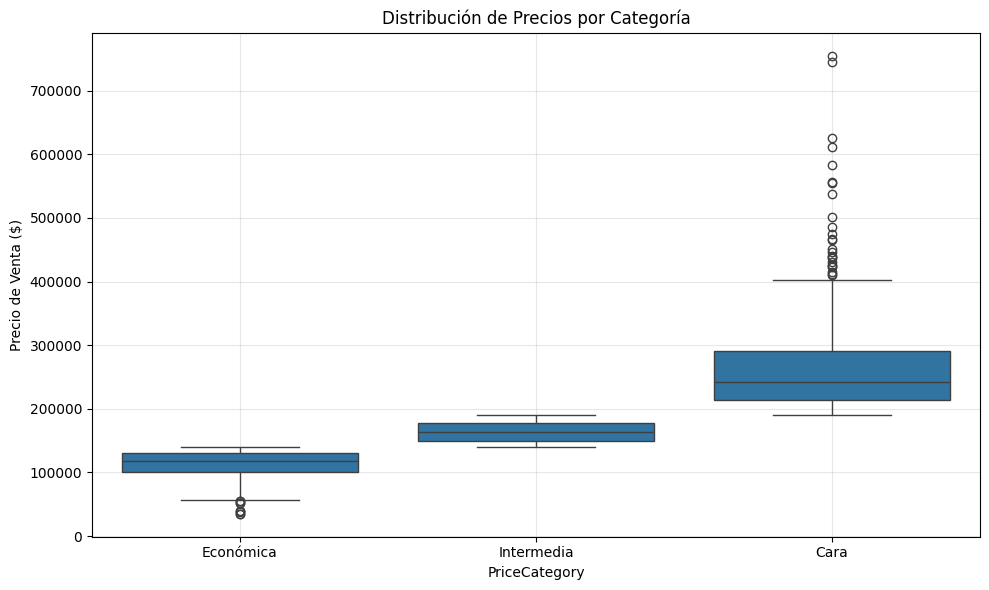

In [17]:
# Cargar los datos
train_data = pd.read_csv('../../train.csv')

# Calcular los tercilos para SalePrice
tercil_1 = np.percentile(train_data['SalePrice'], 33.33)
tercil_2 = np.percentile(train_data['SalePrice'], 66.67)

print(f"Tercil 1 (33.33%): ${int(tercil_1):,}")
print(f"Tercil 2 (66.67%): ${int(tercil_2):,}")

# Crear la variable categórica PriceCategory
train_data['PriceCategory'] = pd.cut(
    train_data['SalePrice'],
    bins=[0, tercil_1, tercil_2, float('inf')],
    labels=['Económica', 'Intermedia', 'Cara'],
    include_lowest=True
)

# Verificar la distribución de las categorías
category_counts = train_data['PriceCategory'].value_counts().sort_index()

# Crear variables dummy (dicotómicas) a partir de PriceCategory
price_dummies = pd.get_dummies(train_data['PriceCategory'], dtype=int)

# Visualizar la distribución de precios por categoría
plt.figure(figsize=(10, 6))
sns.boxplot(x='PriceCategory', y='SalePrice', data=train_data)
plt.title('Distribución de Precios por Categoría')
plt.ylabel('Precio de Venta ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Variables dicotómicas

In [2]:

# Cargar los datos
train_data = pd.read_csv('../../train.csv')

# Calcular los tercilos para SalePrice
tercil_1 = train_data['SalePrice'].quantile(1/3)
tercil_2 = train_data['SalePrice'].quantile(2/3)

# Crear la variable categórica PriceCategory
train_data['PriceCategory'] = pd.cut(
    train_data['SalePrice'],
    bins=[0, tercil_1, tercil_2, float('inf')],
    labels=['Económica', 'Intermedia', 'Cara'],
    include_lowest=True
)

# Crear variables dummy (dicotómicas) a partir de PriceCategory
price_dummies = pd.get_dummies(train_data['PriceCategory'], dtype=int)

price_dummies.head()


,Económica,Intermedia,Cara
0,0,0,1
1,0,1,0
2,0,0,1
3,0,1,0
4,0,0,1


In [3]:
# Unir las variables dummy al dataset original
data_with_dummies = pd.concat([train_data, price_dummies], axis=1)
print("\nDataset con variables dummy (primeras 5 filas):")
data_with_dummies.head()


Dataset con variables dummy (primeras 5 filas):


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PriceCategory,Económica,Intermedia,Cara
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,Cara,0,0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,Intermedia,0,1,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,Cara,0,0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,Intermedia,0,1,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,Cara,0,0,1


In [4]:
# Seleccionar las características más importantes identificadas previamente
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath'        # Baños completos
]

X = data_with_dummies[selected_features].copy()

# Normalizar/estandarizar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)



## Validación Cruzada
Función usada más adelante

In [5]:
# Configurar la validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Función para aplicar validación cruzada a los modelos
def aplicar_validacion_cruzada(X, y, nombre_categoria):
    # Crear modelo de regresión logística
    modelo = LogisticRegression(solver='liblinear')
    
    # Realizar validación cruzada
    resultados_cv = cross_validate(
        modelo, 
        X, 
        y, 
        cv=kfold, 
        scoring=scoring,
        return_train_score=False
    )
    
    # Mostrar resultados
    print(f"\nRESULTADOS CON VALIDACIÓN CRUZADA - CASAS '{nombre_categoria}'")
    print(f"Accuracy: {np.mean(resultados_cv['test_accuracy']):.4f} (±{np.std(resultados_cv['test_accuracy']):.4f})")
    print(f"Precision: {np.mean(resultados_cv['test_precision']):.4f} (±{np.std(resultados_cv['test_precision']):.4f})")
    print(f"Recall: {np.mean(resultados_cv['test_recall']):.4f} (±{np.std(resultados_cv['test_recall']):.4f})")
    print(f"F1-Score: {np.mean(resultados_cv['test_f1']):.4f} (±{np.std(resultados_cv['test_f1']):.4f})")
    print(f"AUROC: {np.mean(resultados_cv['test_roc_auc']):.4f} (±{np.std(resultados_cv['test_roc_auc']):.4f})")
    
    return resultados_cv


## Caras

MODELO PARA PREDECIR CASAS 'CARAS'
Accuracy: 0.9201
Precision: 0.8824
Recall: 0.8633
F1-Score: 0.8727
AUROC: 0.9770
Matriz de confusión:
[[283  16]
 [ 19 120]]


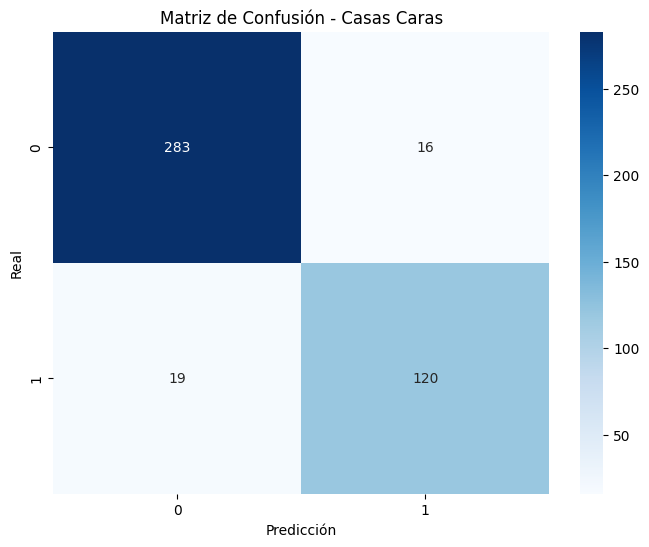

In [6]:
# ----- MODELO 1: PREDECIR SI UNA CASA ES "CARA" -----

# Variable objetivo: 1 si es cara, 0 si no
y_cara = price_dummies['Cara']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_cara, test_size=0.3, random_state=42
)

# Crear y entrenar el modelo
log_reg_cara = LogisticRegression(solver='liblinear')
log_reg_cara.fit(X_train, y_train)

# Realizar predicciones
y_pred = log_reg_cara.predict(X_test)
y_proba = log_reg_cara.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

# Evaluar el modelo
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_proba)

print("MODELO PARA PREDECIR CASAS 'CARAS'")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Matriz de confusión:")
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Casas Caras")
plt.show()





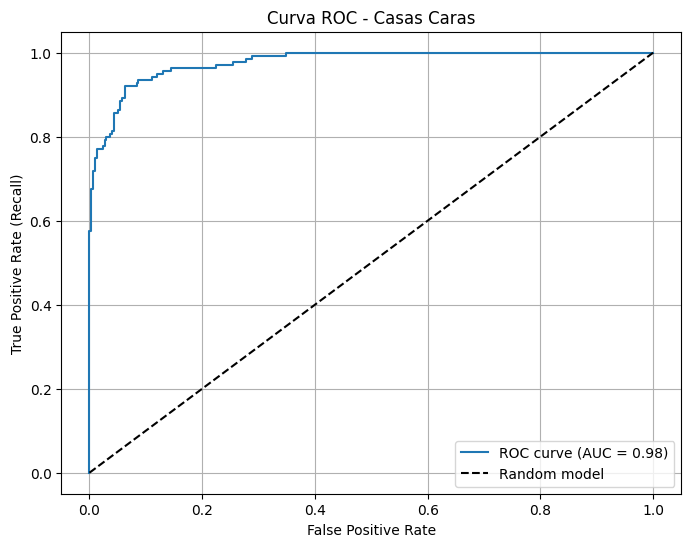

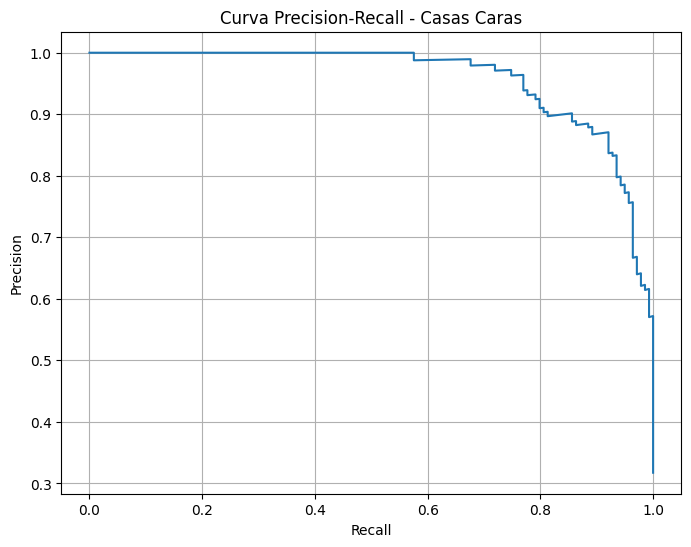

In [7]:
# Visualizar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auroc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC - Casas Caras")
plt.legend()
plt.grid(True)
plt.show()

# Visualizar curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Casas Caras")
plt.grid(True)
plt.show()

## Económicas


MODELO PARA PREDECIR CASAS 'ECONÓMICAS'
Accuracy: 0.8790
Precision: 0.8000
Recall: 0.8774
F1-Score: 0.8369
AUROC: 0.9531
Matriz de confusión:
[[249  34]
 [ 19 136]]


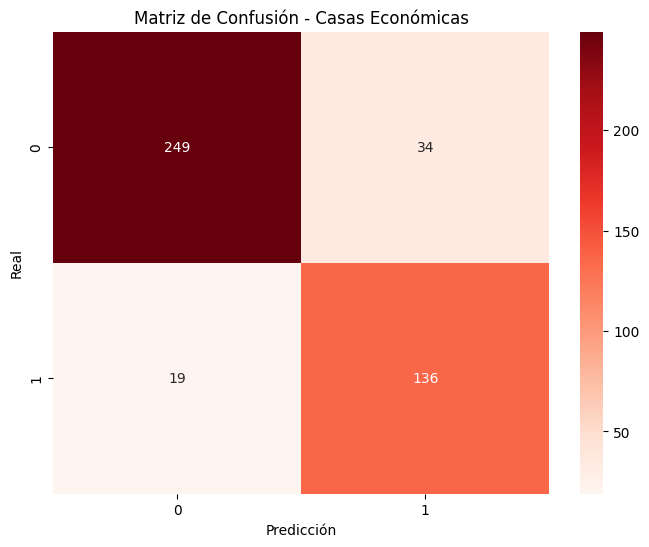

In [8]:
# ----- MODELO 2: PREDECIR SI UNA CASA ES "ECONÓMICA" -----

# Variable objetivo: 1 si es económica, 0 si no
y_economica = price_dummies['Económica']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_economica, test_size=0.3, random_state=42, 
)

# Crear y entrenar el modelo
log_reg_economica = LogisticRegression(solver='liblinear')
log_reg_economica.fit(X_train, y_train)

# Realizar predicciones
y_pred = log_reg_economica.predict(X_test)
y_proba = log_reg_economica.predict_proba(X_test)[:, 1]

# Evaluar el modelo
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_proba)

print("\nMODELO PARA PREDECIR CASAS 'ECONÓMICAS'")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Matriz de confusión:")
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Casas Económicas")
plt.show()





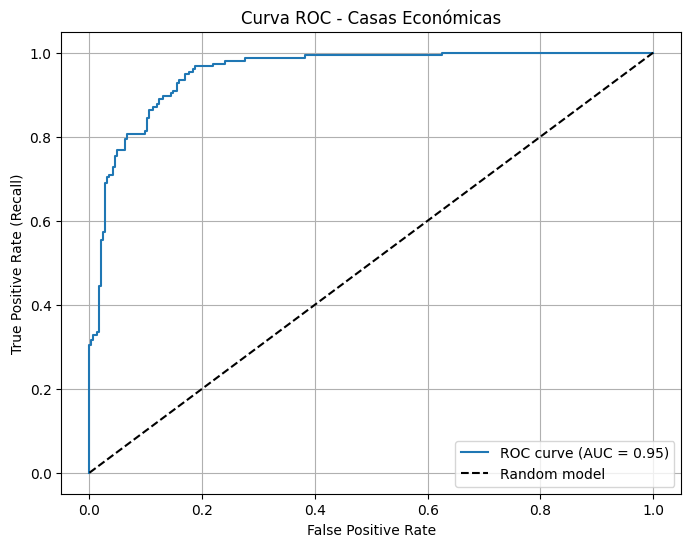

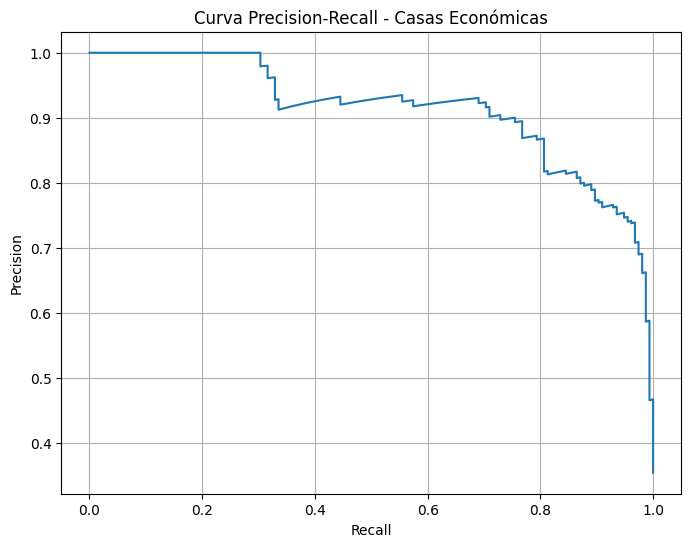

In [9]:
# Visualizar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auroc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC - Casas Económicas")
plt.legend()
plt.grid(True)
plt.show()

# Visualizar curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Casas Económicas")
plt.grid(True)
plt.show()

## Intermedias


MODELO PARA PREDECIR CASAS 'INTERMEDIAS'
Accuracy: 0.6530
Precision: 0.1000
Recall: 0.0069
F1-Score: 0.0130
AUROC: 0.6062
Matriz de confusión:
[[285   9]
 [143   1]]


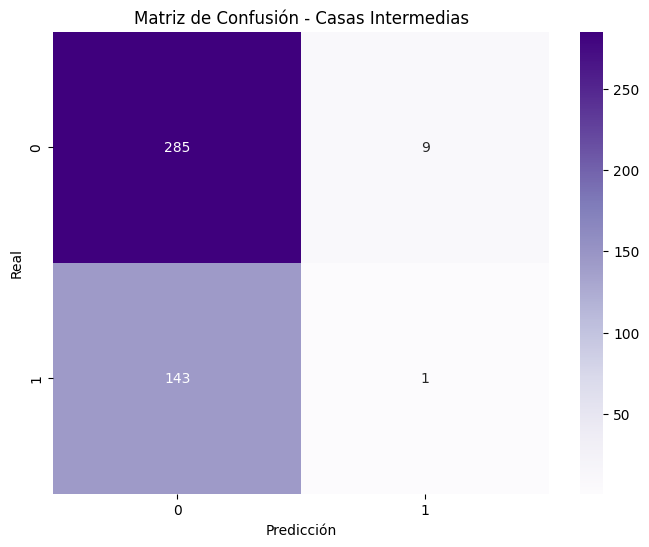

In [ ]:
# ----- MODELO 3: PREDECIR SI UNA CASA ES "INTERMEDIA" -----

# Variable objetivo: 1 si es intermedia, 0 si no
y_intermedia = price_dummies['Intermedia']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_intermedia, test_size=0.3, random_state=42
)

# Crear y entrenar el modelo
log_reg_intermedia = LogisticRegression(solver='liblinear')
log_reg_intermedia.fit(X_train, y_train)

# Realizar predicciones
y_pred = log_reg_intermedia.predict(X_test)
y_proba = log_reg_intermedia.predict_proba(X_test)[:, 1]

# Evaluar el modelo
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_proba)

print("\nMODELO PARA PREDECIR CASAS 'INTERMEDIAS'")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Matriz de confusión:")
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Casas Intermedias")
plt.show()

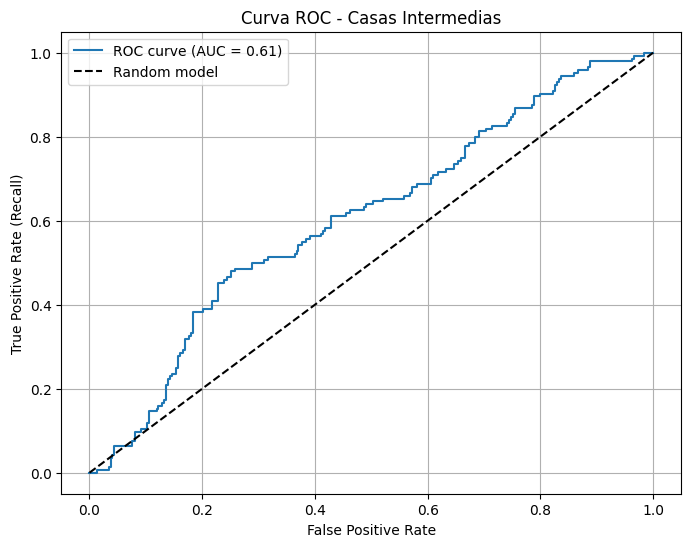

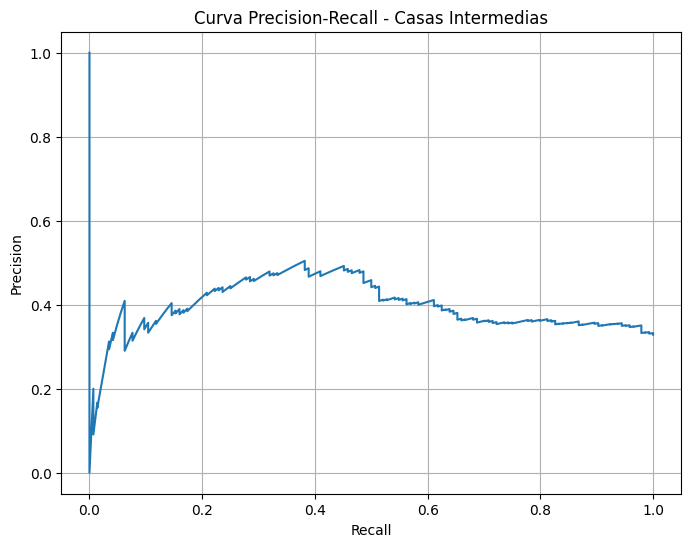

In [11]:
# Visualizar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auroc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC - Casas Intermedias")
plt.legend()
plt.grid(True)
plt.show()

# Visualizar curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Casas Intermedias")
plt.grid(True)
plt.show()

## Métricas De Validación cruzada 

Aplicando validación cruzada a los modelos...

RESULTADOS CON VALIDACIÓN CRUZADA - CASAS 'CARA'
Accuracy: 0.9158 (±0.0228)
Precision: 0.8809 (±0.0451)
Recall: 0.8633 (±0.0306)
F1-Score: 0.8716 (±0.0339)
AUROC: 0.9700 (±0.0199)

RESULTADOS CON VALIDACIÓN CRUZADA - CASAS 'ECONÓMICA'
Accuracy: 0.8918 (±0.0154)
Precision: 0.8297 (±0.0600)
Recall: 0.8536 (±0.0386)
F1-Score: 0.8391 (±0.0270)
AUROC: 0.9531 (±0.0074)

RESULTADOS CON VALIDACIÓN CRUZADA - CASAS 'INTERMEDIA'
Accuracy: 0.6521 (±0.0202)
Precision: 0.1682 (±0.1444)
Recall: 0.0147 (±0.0163)
F1-Score: 0.0263 (±0.0286)
AUROC: 0.6074 (±0.0340)


c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


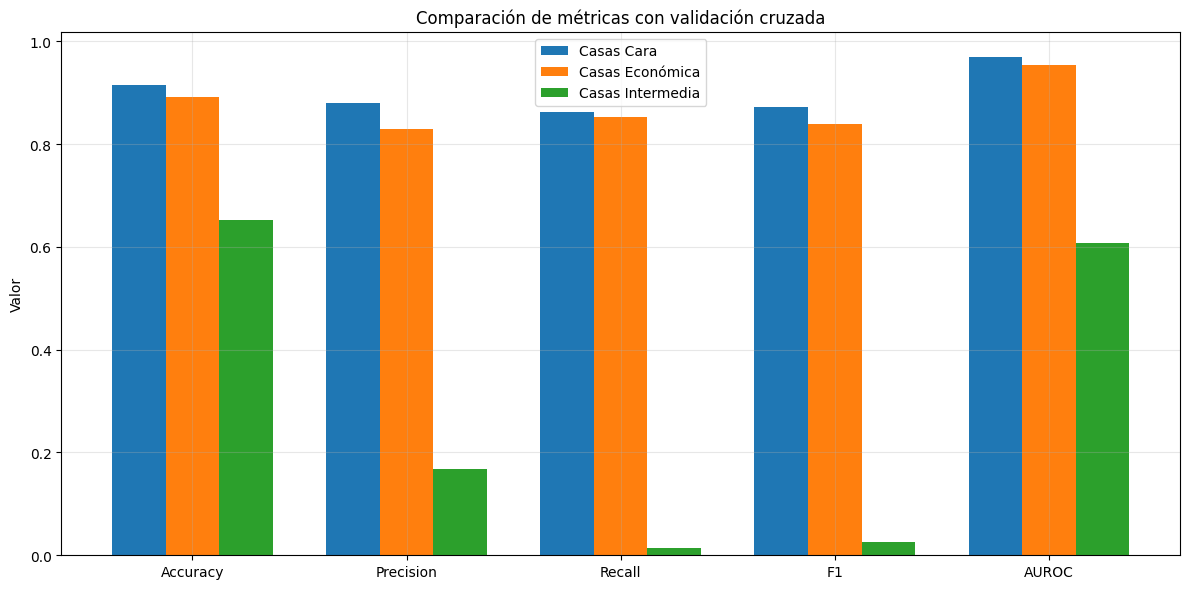

In [12]:
# Aplicar validación cruzada a los tres modelos
print("Aplicando validación cruzada a los modelos...")
# Para casas caras
resultados_cara = aplicar_validacion_cruzada(X_scaled_df, y_cara, "CARA")

# Para casas económicas
resultados_economica = aplicar_validacion_cruzada(X_scaled_df, y_economica, "ECONÓMICA")

# Para casas intermedias
resultados_intermedia = aplicar_validacion_cruzada(X_scaled_df, y_intermedia, "INTERMEDIA")

# Comparación gráfica de los resultados
categorias = ['Cara', 'Económica', 'Intermedia']
metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']
resultados = [
    [np.mean(resultados_cara['test_accuracy']), np.mean(resultados_cara['test_precision']), 
     np.mean(resultados_cara['test_recall']), np.mean(resultados_cara['test_f1']), 
     np.mean(resultados_cara['test_roc_auc'])],
    [np.mean(resultados_economica['test_accuracy']), np.mean(resultados_economica['test_precision']), 
     np.mean(resultados_economica['test_recall']), np.mean(resultados_economica['test_f1']), 
     np.mean(resultados_economica['test_roc_auc'])],
    [np.mean(resultados_intermedia['test_accuracy']), np.mean(resultados_intermedia['test_precision']), 
     np.mean(resultados_intermedia['test_recall']), np.mean(resultados_intermedia['test_f1']), 
     np.mean(resultados_intermedia['test_roc_auc'])]
]

# Crear gráfico comparativo
plt.figure(figsize=(12, 6))
x = np.arange(len(metricas))
width = 0.25

for i, (categoria, resultado) in enumerate(zip(categorias, resultados)):
    plt.bar(x + (i-1)*width, resultado, width, label=f'Casas {categoria}')

plt.ylabel('Valor')
plt.title('Comparación de métricas con validación cruzada')
plt.xticks(x, metricas)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis de multicolinealidad

MATRIZ DE CORRELACIÓN


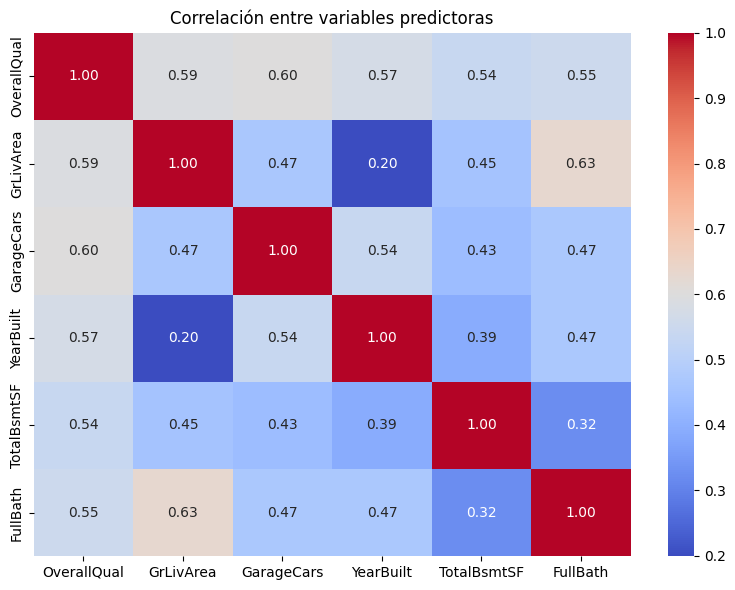


ANÁLISIS DE MULTICOLINEALIDAD (VIF)
      Variable        VIF
0  OverallQual  46.420747
3    YearBuilt  22.592204
1    GrLivArea  18.899734
5     FullBath  16.906668
2   GarageCars  11.076450
4  TotalBsmtSF  10.244002
Interpretación: VIF > 5 indica posible multicolinealidad

ANÁLISIS DE SIGNIFICACIÓN

Modelo CARA - Resumen de significación:
                 Coef.         P>|z|
const       -78.059938  6.241547e-13
OverallQual   1.128174  2.459158e-17
GrLivArea     0.004104  1.620796e-25
GarageCars    0.630953  1.559803e-02
YearBuilt     0.030804  3.392007e-08
TotalBsmtSF   0.001741  2.286271e-09
FullBath     -0.367268  1.927923e-01
Variables significativas (p<0.05):
['const', 'OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'TotalBsmtSF']

Modelo ECONÓMICA - Resumen de significación:
                 Coef.         P>|z|
const        91.608948  1.181237e-24
OverallQual  -1.128878  5.412896e-19
GrLivArea    -0.003093  7.118841e-18
GarageCars   -0.973879  5.308431e-10
YearBuilt    -

In [13]:
# Análisis simple de multicolinealidad y significación
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Análisis de correlación entre variables
print("MATRIZ DE CORRELACIÓN")
correlation = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre variables predictoras')
plt.tight_layout()
plt.show()

# 2. Cálculo del VIF para detectar multicolinealidad
print("\nANÁLISIS DE MULTICOLINEALIDAD (VIF)")
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif.sort_values('VIF', ascending=False))
print("Interpretación: VIF > 5 indica posible multicolinealidad")

# 3. Análisis de significación de variables
print("\nANÁLISIS DE SIGNIFICACIÓN")

# Agregar constante para el intercepto
X_sm = sm.add_constant(X)

# Analizar significación para modelo CARA
model_cara = sm.Logit(y_cara, X_sm).fit(disp=0)
print("\nModelo CARA - Resumen de significación:")
print(model_cara.summary2().tables[1][['Coef.', 'P>|z|']])
print("Variables significativas (p<0.05):")
print(model_cara.summary2().tables[1][model_cara.pvalues < 0.05].index.tolist())

# Analizar significación para modelo ECONÓMICA
model_economica = sm.Logit(y_economica, X_sm).fit(disp=0)
print("\nModelo ECONÓMICA - Resumen de significación:")
print(model_economica.summary2().tables[1][['Coef.', 'P>|z|']])
print("Variables significativas (p<0.05):")
print(model_economica.summary2().tables[1][model_economica.pvalues < 0.05].index.tolist())

# 4. Bondad de ajuste del modelo
print("\nBONDAD DE AJUSTE")
print("\nModelo CARA:")
print(f"Pseudo R-cuadrado: {model_cara.prsquared:.4f}")
print(f"AIC: {model_cara.aic:.2f}")
print(f"Log-Likelihood: {model_cara.llf:.2f}")

print("\nModelo ECONÓMICA:")
print(f"Pseudo R-cuadrado: {model_economica.prsquared:.4f}")
print(f"AIC: {model_economica.aic:.2f}")
print(f"Log-Likelihood: {model_economica.llf:.2f}")


## Modelo a evaluar
Casas caras o no

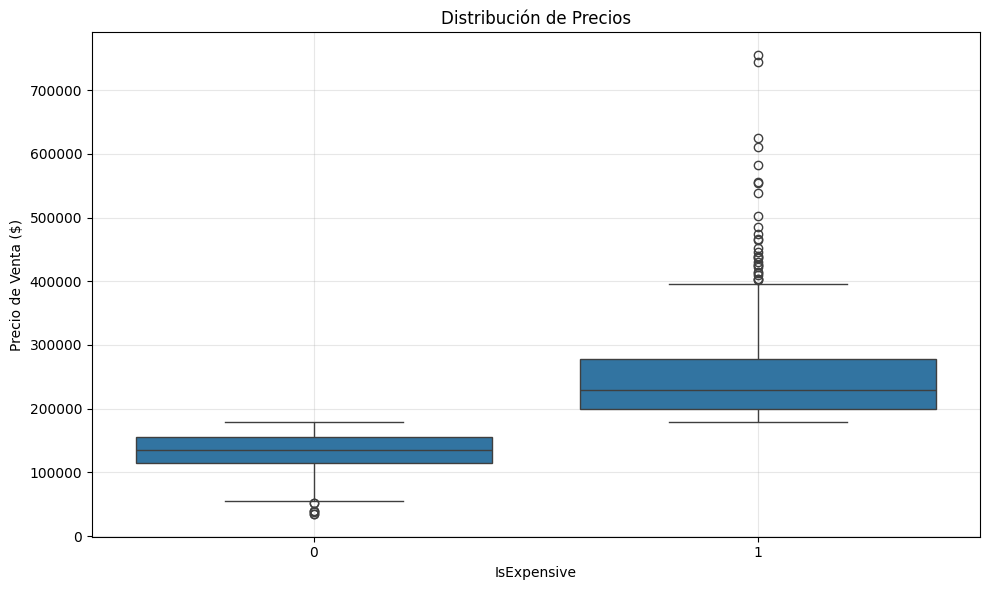

In [ ]:
# Crear la variable de respuesta categórica
# Definir umbral
umbral_precio = train_data['SalePrice'].quantile(0.60)

# Crear la variable binaria
train_data['IsExpensive'] = (train_data['SalePrice'] > umbral_precio).astype(int)

# Preparar los datos
X = train_data[selected_features].copy()
y = train_data['IsExpensive']

# Normalizar/estandarizar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Visualizar la distribución de precios por categoría
plt.figure(figsize=(10, 6))
sns.boxplot(x='IsExpensive', y='SalePrice', data=train_data)
plt.title('Distribución de Precios')
plt.ylabel('Precio de Venta ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



MODELO PARA PREDECIR CASAS CARAS
Accuracy: 0.8790
Precision: 0.8547
Recall: 0.8400
F1-Score: 0.8473
AUROC: 0.9539
Matriz de confusión:
[[238  25]
 [ 28 147]]


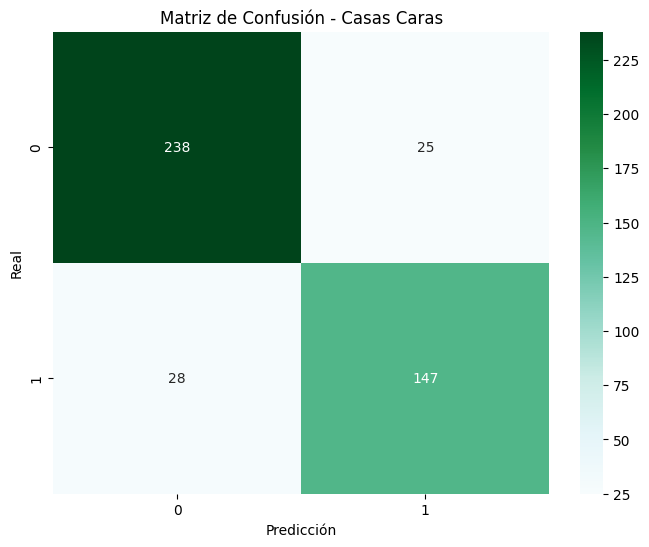

In [46]:
# ----- MODELO 4: PREDECIR SI UNA CASA ES, O NO, CARA -----
# Crear y entrenar el modelo
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# Realizar predicciones
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluar el modelo
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_proba)

print("\nMODELO PARA PREDECIR CASAS CARAS")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Matriz de confusión:")
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Casas Caras")
plt.show()

In [47]:
# Aplicar validación cruzada al modelo
print("Aplicar validación cruzada al modelo...")
# Para casas caras
resultados_cara = aplicar_validacion_cruzada(X_scaled_df, y, "CARAS")

Aplicar validación cruzada al modelo...

RESULTADOS CON VALIDACIÓN CRUZADA - CASAS 'CARAS'
Accuracy: 0.9075 (±0.0258)
Precision: 0.8884 (±0.0430)
Recall: 0.8818 (±0.0233)
F1-Score: 0.8846 (±0.0291)
AUROC: 0.9670 (±0.0145)


## Evaluar Overfitting

In [48]:
from sklearn.metrics import accuracy_score, log_loss

# Predicciones en entrenamiento
y_train_pred = log_reg.predict(X_train)
y_train_proba = log_reg.predict_proba(X_train)[:, 1]

# Calcular accuracy
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_pred)

# Calcular log-loss
logloss_train = log_loss(y_train, y_train_proba)
logloss_test = log_loss(y_test, y_proba)

print(f"Accuracy - Entrenamiento: {acc_train:.4f}")
print(f"Accuracy - Prueba:        {acc_test:.4f}")
print(f"Log Loss - Entrenamiento: {logloss_train:.4f}")
print(f"Log Loss - Prueba:        {logloss_test:.4f}")

Accuracy - Entrenamiento: 0.8914
Accuracy - Prueba:        0.8790
Log Loss - Entrenamiento: 0.2646
Log Loss - Prueba:        0.2726


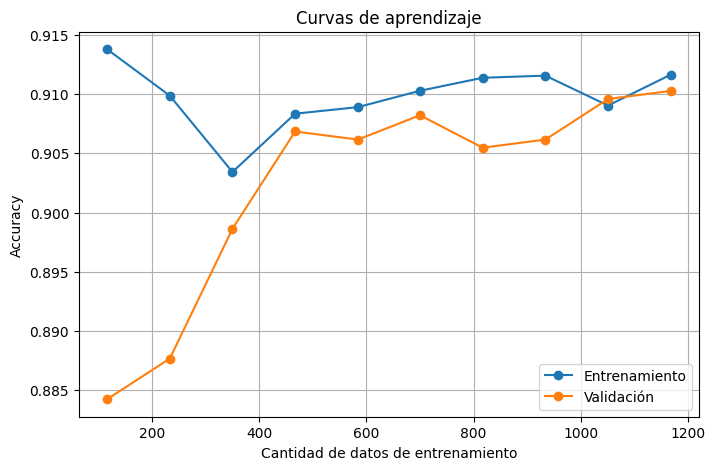

In [49]:
# Curva de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    log_reg, X_scaled, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', n_jobs=-1, shuffle=True, random_state=42
)

# Promediar los resultados
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', label='Validación')
plt.xlabel('Cantidad de datos de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curvas de aprendizaje')
plt.legend()
plt.grid(True)
plt.show()
